In [1]:
import jax.numpy as np
from jax import random, grad, jit, vmap
from functools import partial
key = random.PRNGKey(0)
from jax.experimental import optimizers
from NODE_ICNN_CANN_MF_fns import *
import matplotlib.pyplot as plt
import pickle
from jax.config import config
config.update("jax_enable_x64", True)
import pandas as pd
plt.rcParams.update({'font.size': 12})

/opt/homebrew/lib/python3.9/site-packages/jax/_src/lib/__init__.py:33: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/opt/homebrew/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '


# Train NODE against skin stress data

We have first three types of tests
* strip x
* strip y 
* equibiaxial 

All cases assume fully incompressible plane-stress behavior. For all cases $\sigma_x$ and $\sigma_y$ is given, so the loss is completely based on those values. 

Rough estimate of the normalization factors: 
$lambda_x$ and $\lambda_y$ are in the range $[1,1.5]$ which means that even for equibiaxial the maximum range for the invariants is going to be $I_1 \in [3,5]$ and $I_2 \in [3,6]$ 

On the other hand, the Cauchy stresses are in the range $[0,1]$ MPa 

Considering the expression for the stress of the form $\sigma = \Psi_1 \mathbf{b} + \Psi_2(I_1\mathbf{b}-\mathbf{b}^2) + \Psi_{4a}\mathbf{a}_0 \otimes \mathbf{a}_0 + \Psi_{4s}\mathbf{s}_0 \otimes \mathbf{s}_0 $ then each of the derivatives has to be inside the ranges $\Psi_1 \in [0,0.6]$, $\Psi_2 \in [0,0.46]$, $\Psi_{4a},\Psi_{4s} \in [0,1]$. So based on that we can normalize approximately. Should not be a problem even without normalizing as the ranges are ok. Even in the extreme of $I_2$ being compressed from $[3,6]$ down to 0 I think this is still ok. 

In [2]:
with open('Data/P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
ind_sx = 81
ind_sy = 182
lamb_sigma = np.hstack([lamb,sigma])

In [3]:
## Doing with an object 'model' I still like that 
def eval_Cauchy(lambx,lamby, model, normalization):
    # all normalization constants 
    I1_factor  = normalization[0]
    I2_factor  = normalization[1]
    I4a_factor = normalization[2]
    I4s_factor = normalization[3]
    Psi1_factor = normalization[4]
    Psi2_factor = normalization[5]
    Psi4a_factor = normalization[6]
    Psi4s_factor = normalization[7]
    Psi_1_2_factor = normalization[8]
    Psi_1_4a_factor = normalization[9]
    Psi_1_4s_factor = normalization[10]
    Psi_2_4a_factor = normalization[11]
    Psi_2_4s_factor = normalization[12]
    Psi_4a_4s_factor = normalization[13]
    # I dont want to assemble F, C, etc because not vector friendly 
    # but all these deformations are diagonal so we can compute invariants easily
    # even without explicitly computing the F, C, etc 
    # need to check it but it should be like this: 
    I1 = lambx**2+lamby**2+(1./(lambx*lamby)**2)
    I2 = lambx**2*lamby**2 + lambx**2*(1./(lambx*lamby)**2) + lamby**2*(1./(lambx*lamby)**2) 
    I4a = lambx**2
    I4s = lamby**2
    I1norm = (I1-3)/I1_factor
    I2norm = (I2-3)/I2_factor
    I4anorm = (I4a-1)/I4a_factor
    I4snorm = (I4s-1)/I4s_factor
    # calling all the NODE predictions and undoing normalization 
    # single variable terms 
    Psi1 = model.Psi1norm(I1norm)*Psi1_factor
    Psi2 = model.Psi2norm(I2norm)*Psi2_factor
    Psi4a = 0#model.Psi4anorm(I4anorm)*Psi4a_factor
    Psi4s = 0#model.Psi4snorm(I4snorm)*Psi4s_factor
    # ignore mixed terms 
    Psi_1_2 = 0#model.Psi_1_2_norm(I1norm,I2norm)*Psi_1_2_factor
    Psi_2_1 = 0#model.Psi_2_1_norm(I1norm,I2norm)*Psi_1_2_factor
    Psi_1_4a = model.Psi_1_4a_norm(I1norm,I4anorm)*Psi_1_4a_factor
    Psi_4a_1 = model.Psi_4a_1_norm(I1norm,I4anorm)*Psi_1_4a_factor
    Psi_1_4s = model.Psi_1_4s_norm(I1norm,I4snorm)*Psi_1_4s_factor
    Psi_4s_1 = model.Psi_4s_1_norm(I1norm,I4snorm)*Psi_1_4s_factor
    Psi_2_4a = 0#model.Psi_2_4a_norm(I2norm,I4anorm)*Psi_2_4a_factor
    Psi_4a_2 = 0#model.Psi_4a_2_norm(I2norm,I4anorm)*Psi_2_4a_factor
    Psi_2_4s = 0#model.Psi_2_4s_norm(I2norm,I4snorm)*Psi_2_4s_factor
    Psi_4s_2 = 0#model.Psi_4s_2_norm(I2norm,I4snorm)*Psi_2_4s_factor
    Psi_4a_4s = model.Psi_4a_4s_norm(I4anorm,I4snorm)*Psi_4a_4s_factor
    Psi_4s_4a = model.Psi_4s_4a_norm(I4anorm,I4snorm)*Psi_4a_4s_factor
    
    # get pressure from sigma_33 = 0 
    lambz = 1./(lambx*lamby)
    p = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lambz**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lambz**2 - lambz**4) 
    sigx = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lambx**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lambx**2 - lambx**4) \
            + (Psi4a+Psi_1_4a+Psi_2_4a+Psi_4s_4a)*lambx**2 - p
    sigy = (Psi1+Psi_2_1+Psi_4a_1+Psi_4s_1)*lamby**2 + (Psi2+Psi_1_2+Psi_4a_2+Psi_4s_2)*(I1*lamby**2 - lamby**4) \
            + (Psi4s+Psi_1_4s+Psi_2_4s+Psi_4a_4s)*lamby**2 - p
    return sigx,sigy


In [4]:
## NODE model outputs normalized strain energy given normalized invariants
class NODE_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I4a = params_I4a
        self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
    
    def Psi1norm(self, I1norm):
        return NODE_vmap(I1norm, self.params_I1)
    
    def Psi2norm(self, I2norm):
        return NODE_vmap(I2norm, self.params_I2)
    
    def Psi4anorm(self, I4anorm):
        return NODE_vmap(I4anorm, self.params_I4a)
    
    def Psi4snorm(self, I4snorm):
        return NODE_vmap(I4snorm, self.params_I4s)
    
    def Psi_2_1_norm(self, I1norm, I2norm):
        alpha = self.params_I1_I2[-1]
        K = alpha*(I1norm) + (1-alpha)*(I2norm)
        return alpha*NODE_vmap(K, self.params_I1_I2[:-1])
    
    def Psi_1_2_norm(self, I1norm, I2norm):
        alpha = self.params_I1_I2[-1]
        K = alpha*(I1norm) + (1-alpha)*(I2norm)
        return (1-alpha)*NODE_vmap(K, self.params_I1_I2[:-1])
    
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        return alpha*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4a[:-1])
    
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        return alpha*NODE_vmap(K, self.params_I1_I4s[:-1])
    
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        return (1-alpha)*NODE_vmap(K, self.params_I1_I4s[:-1])

    def Psi_4a_2_norm(self, I2norm, I4anorm):
        alpha = self.params_I2_I4a[-1]
        K = alpha*(I2norm ) + (1-alpha)*(I4anorm )
        return alpha*NODE_vmap(K, self.params_I2_I4a[:-1])
    
    def Psi_2_4a_norm(self, I2norm, I4anorm):
        alpha = self.params_I2_I4a[-1]
        K = alpha*(I2norm ) + (1-alpha)*(I4anorm )
        return (1-alpha)*NODE_vmap(K, self.params_I2_I4a[:-1])
    
    def Psi_4s_2_norm(self, I2norm, I4snorm):
        alpha = self.params_I2_I4s[-1]
        K = alpha*(I2norm ) + (1-alpha)*(I4snorm )
        return alpha*NODE_vmap(K, self.params_I2_I4s[:-1])
    
    def Psi_2_4s_norm(self, I2norm, I4snorm):
        alpha = self.params_I2_I4s[-1]
        K = alpha*(I2norm ) + (1-alpha)*(I4snorm )
        return (1-alpha)*NODE_vmap(K, self.params_I2_I4s[:-1])
    
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm )
        return alpha*NODE_vmap(K, self.params_I4a_I4s[:-1])
    
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm)
        return (1-alpha)*NODE_vmap(K, self.params_I4a_I4s[:-1])

In [5]:
I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_2_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_2_4a_factor = 0.5
Psi_2_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,\
                 Psi1_factor,Psi2_factor,Psi4a_factor,Psi4s_factor,\
                 Psi_1_2_factor,Psi_1_4a_factor,Psi_1_4s_factor,\
                 Psi_2_4a_factor,Psi_2_4s_factor, Psi_4a_4s_factor]

@jit
def loss_sig_all(params, lamb_sigma):
    params_I1 = params[0]
    params_I2 = params[1]
    params_I4a = params[2]
    params_I4s = params[3]
    params_I1_I2 = params[4]
    params_I1_I4a = params[5]
    params_I1_I4s = params[6]
    params_I2_I4a = params[7]
    params_I2_I4s = params[8]
    params_I4a_I4s = params[9]
    # model = NODE_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
    #             params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s)
    model = ICNN_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization)
    # model = CANN_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
    #              params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization)
    lambx = lamb_sigma[:,0]
    lamby = lamb_sigma[:,1]
    sigmax = lamb_sigma[:,2]
    sigmay = lamb_sigma[:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@jit
def loss_sig_e(params, lamb_sigma):
    params_I1 = params[0]
    params_I2 = params[1]
    params_I4a = params[2]
    params_I4s = params[3]
    params_I1_I2 = params[4]
    params_I1_I4a = params[5]
    params_I1_I4s = params[6]
    params_I2_I4a = params[7]
    params_I2_I4s = params[8]
    params_I4a_I4s = params[9]
    # model = NODE_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
    #             params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s)
    model = ICNN_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization)
    # model = CANN_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
    #              params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization)
    lambx = lamb_sigma[:ind_sx,0]
    lamby = lamb_sigma[:ind_sx,1]
    sigmax = lamb_sigma[:ind_sx,2]
    sigmay = lamb_sigma[:ind_sx,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@jit
def loss_sig_sx(params, lamb_sigma):
    params_I1 = params[0]
    params_I2 = params[1]
    params_I4a = params[2]
    params_I4s = params[3]
    params_I1_I2 = params[4]
    params_I1_I4a = params[5]
    params_I1_I4s = params[6]
    params_I2_I4a = params[7]
    params_I2_I4s = params[8]
    params_I4a_I4s = params[9]
    # model = NODE_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
    #             params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s)
    model = ICNN_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization)
    # model = CANN_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
    #              params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization)
    lambx = lamb_sigma[ind_sx:ind_sy,0]
    lamby = lamb_sigma[ind_sx:ind_sy,1]
    sigmax = lamb_sigma[ind_sx:ind_sy,2]
    sigmay = lamb_sigma[ind_sx:ind_sy,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@jit
def loss_sig_sy(params, lamb_sigma):
    params_I1 = params[0]
    params_I2 = params[1]
    params_I4a = params[2]
    params_I4s = params[3]
    params_I1_I2 = params[4]
    params_I1_I4a = params[5]
    params_I1_I4s = params[6]
    params_I2_I4a = params[7]
    params_I2_I4s = params[8]
    params_I4a_I4s = params[9]
    # model = NODE_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
    #             params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s)
    model = ICNN_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization)
    # model = CANN_model(params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
    #              params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization)
    lambx = lamb_sigma[ind_sy:,0]
    lamby = lamb_sigma[ind_sy:,1]
    sigmax = lamb_sigma[ind_sy:,2]
    sigmay = lamb_sigma[ind_sy:,3]
    sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)
    return np.mean((sigx-sigmax)**2+(sigy-sigmay)**2)

@partial(jit, static_argnums=(0,))
def step_jp(loss, i, opt_state, X_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch)
    return opt_update(i, g, opt_state)

def train_jp(loss, X, opt_state, key, nIter = 10000):
    train_loss = []
    val_loss = []
    for it in range(nIter):
        opt_state = step_jp(loss, it, opt_state, X)         
        if (it+1)% 1000 == 0:
            params = get_params(opt_state)
            train_loss_value = loss(params, X)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it+1, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss



In [6]:
layers = [1, 5, 5, 1]
#layersI2 = [1, 2, 2, 1]
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
#params_I2=[0.0]
#params_I4a = init_params(layers, key)
params_I4a=[0.0]
#params_I4s = init_params(layers, key)
params_I4s=[0.0]
#params_I1_I2 = init_params(layers, key)
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params(layers, key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params(layers, key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
#params_I2_I4a = init_params(layers, key)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
#params_I2_I4s = init_params(layers, key)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params(layers, key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_a = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_a)
params_a, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma, opt_state, key, nIter = 70000) #Original 100000

it 1000, train loss = 4.215305e-03
it 2000, train loss = 2.893970e-03
it 3000, train loss = 2.512575e-03
it 4000, train loss = 2.289494e-03
it 5000, train loss = 2.145945e-03
it 6000, train loss = 2.010509e-03
it 7000, train loss = 1.767871e-03
it 8000, train loss = 1.138965e-03
it 9000, train loss = 1.098208e-03
it 10000, train loss = 1.047056e-03
it 11000, train loss = 1.790610e-04
it 12000, train loss = 1.570084e-04
it 13000, train loss = 1.554429e-04
it 14000, train loss = 1.540794e-04
it 15000, train loss = 1.529057e-04
it 16000, train loss = 1.518744e-04
it 17000, train loss = 1.510809e-04
it 18000, train loss = 1.503793e-04
it 19000, train loss = 1.497152e-04
it 20000, train loss = 1.490710e-04
it 21000, train loss = 1.484377e-04
it 22000, train loss = 1.478005e-04
it 23000, train loss = 1.471402e-04
it 24000, train loss = 1.463952e-04
it 25000, train loss = 1.454991e-04
it 26000, train loss = 1.440010e-04
it 27000, train loss = 1.417493e-04
it 28000, train loss = 1.395834e-04
i

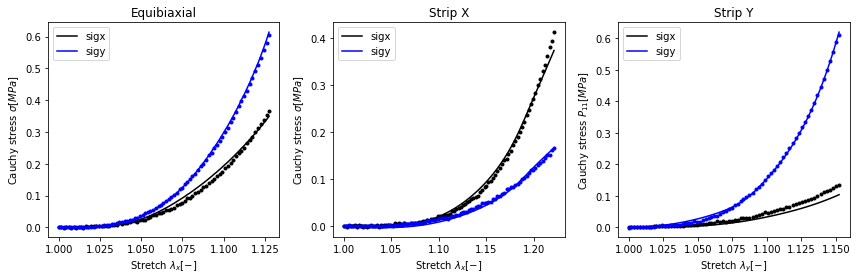

In [7]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = NODE_model(params_a[0], params_a[1], params_a[2], params_a[3], params_a[4], \
                 params_a[5], params_a[6], params_a[7], params_a[8], params_a[9])
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('NODE_skin_trained_all.png',dpi=200)

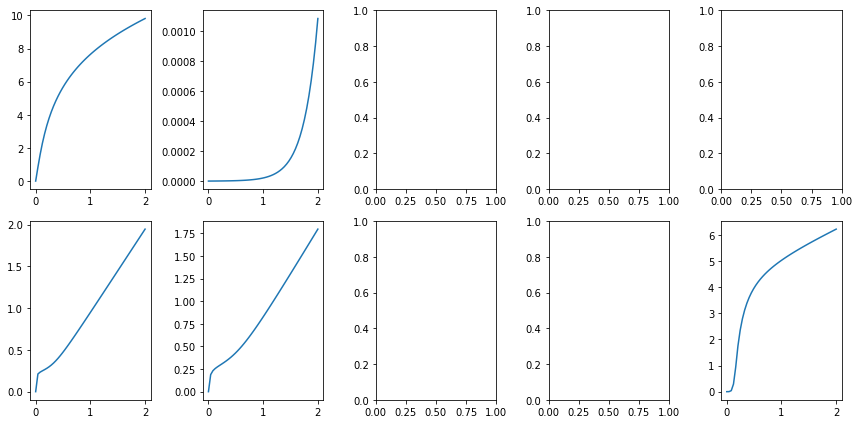

In [8]:
## let's plot all ten NODEs
Ivec = np.linspace(0,2,50)
fig,axs = plt.subplots(2,5,figsize=(12,6))
axs[0,0].plot(Ivec,NODE_vmap(Ivec, params_a[0]))
axs[0,1].plot(Ivec,NODE_vmap(Ivec, params_a[1]))
#axs[0,2].plot(Ivec,NN(Ivec, params_a[2]))
#axs[0,3].plot(Ivec,NN(Ivec, params_a[3]))
#axs[0,4].plot(Ivec,NN(Ivec, params_a[4][:-1]))
axs[1,0].plot(Ivec,NODE_vmap(Ivec, params_a[5][:-1]))
axs[1,1].plot(Ivec,NODE_vmap(Ivec, params_a[6][:-1]))
#axs[1,2].plot(Ivec,NN(Ivec, params_a[7][:-1]))
#axs[1,3].plot(Ivec,NN(Ivec, params_a[8][:-1]))
axs[1,4].plot(Ivec,NODE_vmap(Ivec, params_a[9][:-1]))
plt.tight_layout()

In [9]:
# save the result with pickle
with open('savednet/NODE_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_a, f)

## Training with one set of data and comparing to the others 

In [42]:
layers = [1, 5, 5, 1]
#layersI2 = [1, 2, 2, 1]
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
#params_I2=[0.0]
#params_I4a = init_params(layers, key)
params_I4a=[0.0]
#params_I4s = init_params(layers, key)
params_I4s=[0.0]
#params_I1_I2 = init_params(layers, key)
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params(layers, key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params(layers, key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
#params_I2_I4a = init_params(layers, key)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
#params_I2_I4s = init_params(layers, key)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params(layers, key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_e = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_e)
params_e, train_loss, val_loss = train_jp(loss_sig_e, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 4.641122e-03
it 2000, train loss = 2.147657e-03
it 3000, train loss = 1.560942e-03
it 4000, train loss = 1.254631e-03
it 5000, train loss = 1.040208e-03
it 6000, train loss = 8.722781e-04
it 7000, train loss = 7.213356e-04
it 8000, train loss = 1.429694e-04
it 9000, train loss = 7.324379e-05
it 10000, train loss = 4.258205e-05
it 11000, train loss = 3.607185e-05
it 12000, train loss = 3.382938e-05
it 13000, train loss = 3.186234e-05
it 14000, train loss = 3.010977e-05
it 15000, train loss = 2.854477e-05
it 16000, train loss = 2.700195e-05
it 17000, train loss = 2.312648e-05
it 18000, train loss = 1.600368e-05
it 19000, train loss = 9.946552e-06
it 20000, train loss = 6.976497e-06
it 21000, train loss = 6.660599e-06
it 22000, train loss = 6.486249e-06
it 23000, train loss = 6.364130e-06
it 24000, train loss = 6.272626e-06
it 25000, train loss = 6.200360e-06
it 26000, train loss = 6.141019e-06
it 27000, train loss = 6.089305e-06
it 28000, train loss = 6.043262e-06
i

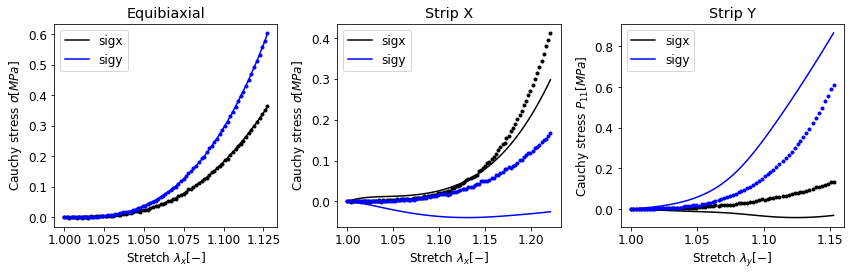

In [45]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = NODE_model(params_e[0], params_e[1], params_e[2], params_e[3], params_e[4], \
                 params_e[5], params_e[6], params_e[7], params_e[8], params_e[9])
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('NODE_skin_trained_equi.png',dpi=200)

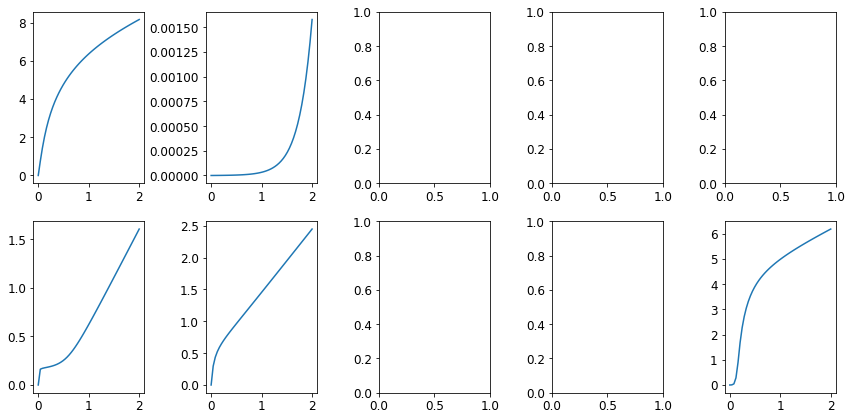

In [46]:

## let's plot all ten NODEs
Ivec = np.linspace(0,2,50)
fig,axs = plt.subplots(2,5,figsize=(12,6))
axs[0,0].plot(Ivec,NODE_vmap(Ivec, params_a[0]))
axs[0,1].plot(Ivec,NODE_vmap(Ivec, params_a[1]))
#axs[0,2].plot(Ivec,NN(Ivec, params_a[2]))
#axs[0,3].plot(Ivec,NN(Ivec, params_a[3]))
#axs[0,4].plot(Ivec,NN(Ivec, params_a[4][:-1]))
axs[1,0].plot(Ivec,NODE_vmap(Ivec, params_a[5][:-1]))
axs[1,1].plot(Ivec,NODE_vmap(Ivec, params_a[6][:-1]))
#axs[1,2].plot(Ivec,NN(Ivec, params_a[7][:-1]))
#axs[1,3].plot(Ivec,NN(Ivec, params_a[8][:-1]))
axs[1,4].plot(Ivec,NODE_vmap(Ivec, params_a[9][:-1]))
plt.tight_layout()

In [47]:
# save the result with pickle
with open('savednet/NODE_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_e, f)

In [49]:
layers = [1, 5, 5, 1]
#layersI2 = [1, 2, 2, 1]
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
#params_I2=[0.0]
#params_I4a = init_params(layers, key)
params_I4a=[0.0]
#params_I4s = init_params(layers, key)
params_I4s=[0.0]
#params_I1_I2 = init_params(layers, key)
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params(layers, key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params(layers, key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
#params_I2_I4a = init_params(layers, key)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
#params_I2_I4s = init_params(layers, key)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params(layers, key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_sx = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_sx)
params_sx, train_loss, val_loss = train_jp(loss_sig_sx, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 1.909258e-03
it 2000, train loss = 9.758081e-04
it 3000, train loss = 6.503147e-04
it 4000, train loss = 5.333755e-04
it 5000, train loss = 4.886772e-04
it 6000, train loss = 4.656070e-04
it 7000, train loss = 4.512025e-04
it 8000, train loss = 4.411203e-04
it 9000, train loss = 4.314397e-04
it 10000, train loss = 3.955104e-04
it 11000, train loss = 9.170463e-05
it 12000, train loss = 8.864811e-05
it 13000, train loss = 3.188999e-05
it 14000, train loss = 2.784729e-05
it 15000, train loss = 2.708347e-05
it 16000, train loss = 2.572558e-05
it 17000, train loss = 2.267424e-05
it 18000, train loss = 1.932704e-05
it 19000, train loss = 1.799222e-05
it 20000, train loss = 1.766728e-05
it 21000, train loss = 1.748084e-05
it 22000, train loss = 1.730733e-05
it 23000, train loss = 1.721282e-05
it 24000, train loss = 1.716290e-05
it 25000, train loss = 1.713193e-05
it 26000, train loss = 1.710726e-05
it 27000, train loss = 1.708498e-05
it 28000, train loss = 1.706466e-05
i

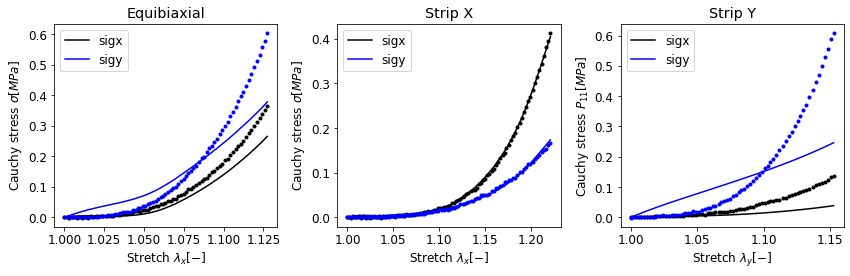

In [50]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = NODE_model(params_sx[0], params_sx[1], params_sx[2], params_sx[3], params_sx[4], \
                 params_sx[5], params_sx[6], params_sx[7], params_sx[8], params_sx[9])
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('NODE_skin_trained_sx.png',dpi=200)

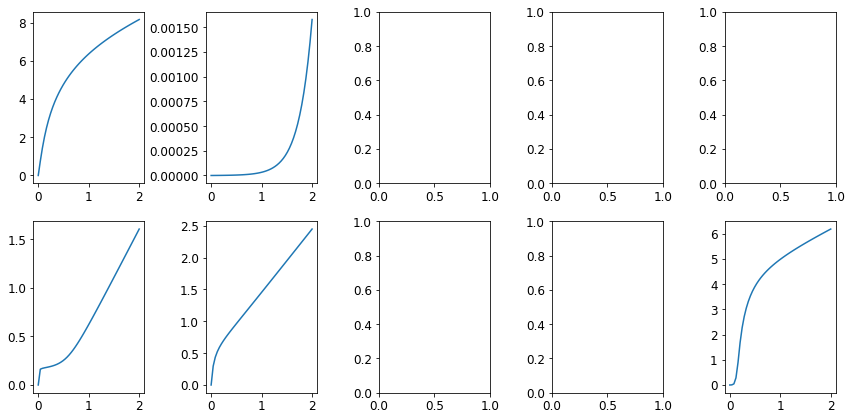

In [51]:

## let's plot all ten NODEs
Ivec = np.linspace(0,2,50)
fig,axs = plt.subplots(2,5,figsize=(12,6))
axs[0,0].plot(Ivec,NODE_vmap(Ivec, params_a[0]))
axs[0,1].plot(Ivec,NODE_vmap(Ivec, params_a[1]))
#axs[0,2].plot(Ivec,NN(Ivec, params_a[2]))
#axs[0,3].plot(Ivec,NN(Ivec, params_a[3]))
#axs[0,4].plot(Ivec,NN(Ivec, params_a[4][:-1]))
axs[1,0].plot(Ivec,NODE_vmap(Ivec, params_a[5][:-1]))
axs[1,1].plot(Ivec,NODE_vmap(Ivec, params_a[6][:-1]))
#axs[1,2].plot(Ivec,NN(Ivec, params_a[7][:-1]))
#axs[1,3].plot(Ivec,NN(Ivec, params_a[8][:-1]))
axs[1,4].plot(Ivec,NODE_vmap(Ivec, params_a[9][:-1]))
plt.tight_layout()

In [52]:
# save the result with pickle
with open('savednet/NODE_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_sx, f)

In [54]:
layers = [1, 5, 5, 1]
#layersI2 = [1, 2, 2, 1]
params_I1 = init_params(layers, key)
params_I2 = init_params(layers, key)
#params_I2=[0.0]
#params_I4a = init_params(layers, key)
params_I4a=[0.0]
#params_I4s = init_params(layers, key)
params_I4s=[0.0]
#params_I1_I2 = init_params(layers, key)
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params(layers, key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params(layers, key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
#params_I2_I4a = init_params(layers, key)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
#params_I2_I4s = init_params(layers, key)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params(layers, key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_sy = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_sy)
params_sy, train_loss, val_loss = train_jp(loss_sig_sy, lamb_sigma, opt_state, key, nIter = 50000) #Original 100000

it 1000, train loss = 5.530217e-03
it 2000, train loss = 2.853526e-03
it 3000, train loss = 1.432703e-03
it 4000, train loss = 9.060081e-04
it 5000, train loss = 6.522694e-04
it 6000, train loss = 5.030478e-04
it 7000, train loss = 4.111225e-04
it 8000, train loss = 3.537705e-04
it 9000, train loss = 3.173145e-04
it 10000, train loss = 2.925386e-04
it 11000, train loss = 2.725842e-04
it 12000, train loss = 2.538892e-04
it 13000, train loss = 2.187695e-04
it 14000, train loss = 1.681792e-04
it 15000, train loss = 1.600816e-04
it 16000, train loss = 1.307289e-04
it 17000, train loss = 4.481874e-05
it 18000, train loss = 4.300245e-05
it 19000, train loss = 4.066743e-05
it 20000, train loss = 3.705761e-05
it 21000, train loss = 3.160884e-05
it 22000, train loss = 2.472157e-05
it 23000, train loss = 1.850728e-05
it 24000, train loss = 1.416814e-05
it 25000, train loss = 1.183375e-05
it 26000, train loss = 1.052789e-05
it 27000, train loss = 9.714161e-06
it 28000, train loss = 9.163805e-06
i

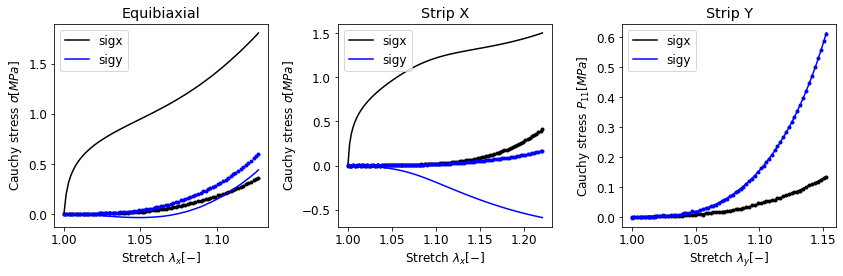

In [55]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = NODE_model(params_sy[0], params_sy[1], params_sy[2], params_sy[3], params_sy[4], \
                 params_sy[5], params_sy[6], params_sy[7], params_sy[8], params_sy[9])
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('NODE_skin_trained_sy.png',dpi=200)

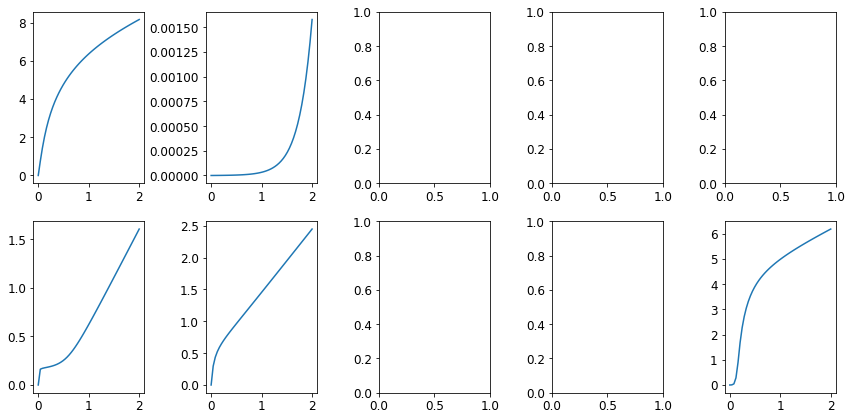

In [56]:
## let's plot all ten NODEs
Ivec = np.linspace(0,2,50)
fig,axs = plt.subplots(2,5,figsize=(12,6))
axs[0,0].plot(Ivec,NODE_vmap(Ivec, params_a[0]))
axs[0,1].plot(Ivec,NODE_vmap(Ivec, params_a[1]))
#axs[0,2].plot(Ivec,NN(Ivec, params_a[2]))
#axs[0,3].plot(Ivec,NN(Ivec, params_a[3]))
#axs[0,4].plot(Ivec,NN(Ivec, params_a[4][:-1]))
axs[1,0].plot(Ivec,NODE_vmap(Ivec, params_a[5][:-1]))
axs[1,1].plot(Ivec,NODE_vmap(Ivec, params_a[6][:-1]))
#axs[1,2].plot(Ivec,NN(Ivec, params_a[7][:-1]))
#axs[1,3].plot(Ivec,NN(Ivec, params_a[8][:-1]))
axs[1,4].plot(Ivec,NODE_vmap(Ivec, params_a[9][:-1]))
plt.tight_layout()

In [57]:
# save the result with pickle
with open('savednet/NODE_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_sy, f)

## Train ICNN

In [6]:
# play with ICNN a bit, how do we get that one to work
class ICNN_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I4a = params_I4a
        self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
        self.normalization = normalization
        
    # Psi1
    # note: for ICNN the prediction is the function not the gradient
    # but the sigma functions expect the gradient so taking derivative
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        f1 = lambda x: icnn_forwardpass(x, self.params_I1)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df1 = grad(f1)
        return vmap(df1)(I1norm[:,None])[:,0]/self.normalization[0]
    
    # Psi2
    # note: for ICNN the prediction is the function not the gradient
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        f2 = lambda x: icnn_forwardpass(x, self.params_I2)[0]
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        df2 = grad(f2)
        return vmap(df2)(I2norm[:,None])[:,0]/self.normalization[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*alpha/self.normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm )
        f_1_4a = lambda x: icnn_forwardpass(x, self.params_I1_I4a[:-1])[0]
        df_1_4a = grad(f_1_4a)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4a)(K[:,None])[:,0]*(1-alpha)/self.normalization[2]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*alpha/self.normalization[0]
    
    # mixed term with I4s and I1
    # output is derivative wrt I4s
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm ) + (1-alpha)*(I4snorm )
        f_1_4s = lambda x: icnn_forwardpass(x, self.params_I1_I4s[:-1])[0]
        df_1_4s = grad(f_1_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_1_4s)(K[:,None])[:,0]*(1-alpha)/self.normalization[3]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4a
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*alpha/self.normalization[2]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm ) + (1-alpha)*(I4snorm )
        f_4a_4s = lambda x: icnn_forwardpass(x, self.params_I4a_I4s[:-1])[0]
        df_4a_4s = grad(f_4a_4s)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return vmap(df_4a_4s)(K[:,None])[:,0]*(1-alpha)/self.normalization[3]
    

In [7]:
layers = [1, 5, 5, 1]
#layersI2 = [1, 2, 2, 1]
params_I1 = init_params_icnn(layers, key)
params_I2 = init_params_icnn(layers, key)
#params_I2=[0.0]
#params_I4a = init_params(layers, key)
params_I4a=[0.0]
#params_I4s = init_params(layers, key)
params_I4s=[0.0]
#params_I1_I2 = init_params(layers, key)
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params_icnn(layers, key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params_icnn(layers, key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
#params_I2_I4a = init_params(layers, key)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
#params_I2_I4s = init_params(layers, key)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params_icnn(layers, key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_icnn_all = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_all)
params_icnn_all, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma, opt_state, key, nIter = 70000) #Original 100000

it 1000, train loss = 7.446060e-02
it 2000, train loss = 2.211002e-02
it 3000, train loss = 1.550222e-02
it 4000, train loss = 1.186549e-02
it 5000, train loss = 9.986066e-03
it 6000, train loss = 8.993247e-03
it 7000, train loss = 8.738984e-03
it 8000, train loss = 8.188859e-03
it 9000, train loss = 5.941291e-03
it 10000, train loss = 4.771370e-03
it 11000, train loss = 4.475777e-03
it 12000, train loss = 4.159453e-03
it 13000, train loss = 3.758258e-03
it 14000, train loss = 3.108071e-03
it 15000, train loss = 2.387247e-03
it 16000, train loss = 1.718748e-03
it 17000, train loss = 1.111547e-03
it 18000, train loss = 4.804526e-04
it 19000, train loss = 3.615725e-04
it 20000, train loss = 3.559641e-04
it 21000, train loss = 3.496553e-04
it 22000, train loss = 3.414617e-04
it 23000, train loss = 3.313450e-04
it 24000, train loss = 3.201861e-04
it 25000, train loss = 3.095976e-04
it 26000, train loss = 3.009445e-04
it 27000, train loss = 2.946909e-04
it 28000, train loss = 2.905814e-04
i

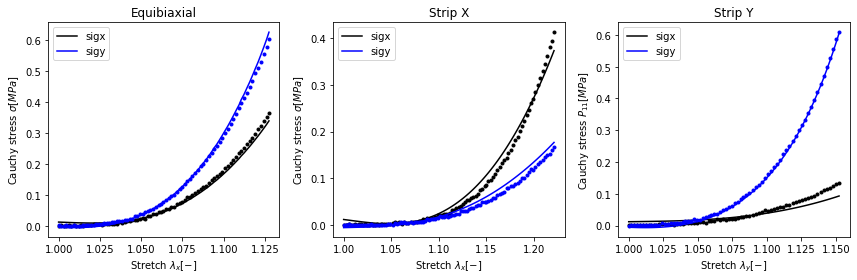

In [8]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = ICNN_model(params_icnn_all[0], params_icnn_all[1], params_icnn_all[2], params_icnn_all[3], params_icnn_all[4], \
                 params_icnn_all[5], params_icnn_all[6], params_icnn_all[7], params_icnn_all[8], params_icnn_all[9],normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('ICNN_skin_trained_all.png',dpi=200)

In [9]:
# save the result with pickle
with open('savednet/ICNN_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_icnn_all, f)

In [10]:
layers = [1, 5, 5, 1]
#layersI2 = [1, 2, 2, 1]
params_I1 = init_params_icnn(layers, key)
params_I2 = init_params_icnn(layers, key)
#params_I2=[0.0]
#params_I4a = init_params(layers, key)
params_I4a=[0.0]
#params_I4s = init_params(layers, key)
params_I4s=[0.0]
#params_I1_I2 = init_params(layers, key)
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params_icnn(layers, key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params_icnn(layers, key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
#params_I2_I4a = init_params(layers, key)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
#params_I2_I4s = init_params(layers, key)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params_icnn(layers, key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_icnn_e = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_e)
params_icnn_e, train_loss, val_loss = train_jp(loss_sig_e, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 1.080993e-01
it 2000, train loss = 2.923280e-02
it 3000, train loss = 1.941601e-02
it 4000, train loss = 1.385354e-02
it 5000, train loss = 1.049368e-02
it 6000, train loss = 7.729593e-03
it 7000, train loss = 6.978354e-03
it 8000, train loss = 6.773073e-03
it 9000, train loss = 6.577976e-03
it 10000, train loss = 6.271861e-03
it 11000, train loss = 5.492459e-03
it 12000, train loss = 3.777376e-03
it 13000, train loss = 2.960100e-03
it 14000, train loss = 6.517848e-04
it 15000, train loss = 2.019585e-04
it 16000, train loss = 1.950539e-04
it 17000, train loss = 1.853244e-04
it 18000, train loss = 1.724787e-04
it 19000, train loss = 1.552562e-04
it 20000, train loss = 1.025085e-04
it 21000, train loss = 1.225040e-05
it 22000, train loss = 9.637693e-06
it 23000, train loss = 9.286817e-06
it 24000, train loss = 8.975203e-06
it 25000, train loss = 8.697407e-06
it 26000, train loss = 8.454001e-06
it 27000, train loss = 8.240277e-06
it 28000, train loss = 8.063910e-06
i

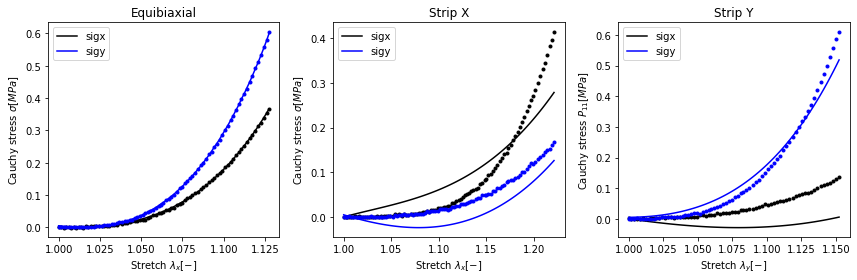

In [11]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = ICNN_model(params_icnn_e[0], params_icnn_e[1], params_icnn_e[2], params_icnn_e[3], params_icnn_e[4], \
                 params_icnn_e[5], params_icnn_e[6], params_icnn_e[7], params_icnn_e[8], params_icnn_e[9],normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('Figures/ICNN_skin_trained_equi.png',dpi=200)

In [12]:
# save the result with pickle
with open('savednet/ICNN_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_icnn_e, f)

In [13]:
layers = [1, 5, 5, 1]
#layersI2 = [1, 2, 2, 1]
params_I1 = init_params_icnn(layers, key)
params_I2 = init_params_icnn(layers, key)
#params_I2=[0.0]
#params_I4a = init_params(layers, key)
params_I4a=[0.0]
#params_I4s = init_params(layers, key)
params_I4s=[0.0]
#params_I1_I2 = init_params(layers, key)
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params_icnn(layers, key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params_icnn(layers, key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
#params_I2_I4a = init_params(layers, key)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
#params_I2_I4s = init_params(layers, key)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params_icnn(layers, key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_icnn_sx = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_sx)
params_icnn_sx, train_loss, val_loss = train_jp(loss_sig_sx, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 4.516178e-02
it 2000, train loss = 9.590145e-03
it 3000, train loss = 6.889461e-03
it 4000, train loss = 5.136428e-03
it 5000, train loss = 4.028962e-03
it 6000, train loss = 3.537414e-03
it 7000, train loss = 3.418126e-03
it 8000, train loss = 3.365359e-03
it 9000, train loss = 3.290713e-03
it 10000, train loss = 3.163473e-03
it 11000, train loss = 2.916225e-03
it 12000, train loss = 2.531315e-03
it 13000, train loss = 2.124869e-03
it 14000, train loss = 1.495441e-03
it 15000, train loss = 2.559369e-04
it 16000, train loss = 1.674352e-04
it 17000, train loss = 1.547733e-04
it 18000, train loss = 1.392599e-04
it 19000, train loss = 1.205254e-04
it 20000, train loss = 9.666871e-05
it 21000, train loss = 7.379140e-05
it 22000, train loss = 5.546745e-05
it 23000, train loss = 4.028617e-05
it 24000, train loss = 2.885962e-05
it 25000, train loss = 2.151033e-05
it 26000, train loss = 1.776213e-05
it 27000, train loss = 1.627112e-05
it 28000, train loss = 1.569648e-05
i

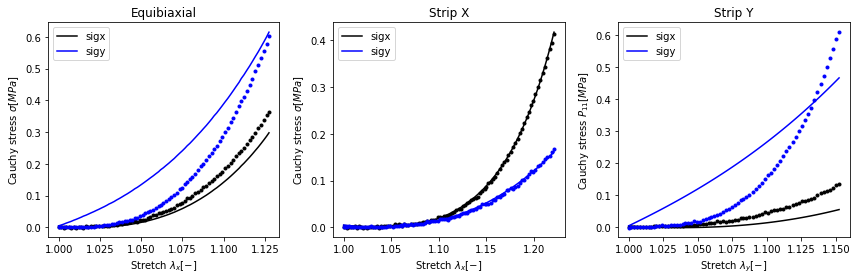

In [14]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = ICNN_model(params_icnn_sx[0], params_icnn_sx[1], params_icnn_sx[2], params_icnn_sx[3], params_icnn_sx[4], \
                 params_icnn_sx[5], params_icnn_sx[6], params_icnn_sx[7], params_icnn_sx[8], params_icnn_sx[9],normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('Figures/ICNN_skin_trained_sx.png',dpi=200)

In [15]:
# save the result with pickle
with open('savednet/ICNN_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_icnn_sx, f)

In [16]:
layers = [1, 5, 5, 1]
#layersI2 = [1, 2, 2, 1]
params_I1 = init_params_icnn(layers, key)
params_I2 = init_params_icnn(layers, key)
#params_I2=[0.0]
#params_I4a = init_params(layers, key)
params_I4a=[0.0]
#params_I4s = init_params(layers, key)
params_I4s=[0.0]
#params_I1_I2 = init_params(layers, key)
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params_icnn(layers, key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params_icnn(layers, key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
#params_I2_I4a = init_params(layers, key)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
#params_I2_I4s = init_params(layers, key)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params_icnn(layers, key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_icnn_sy = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_icnn_sy)
params_icnn_sy, train_loss, val_loss = train_jp(loss_sig_sy, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 7.744813e-02
it 2000, train loss = 2.607965e-02
it 3000, train loss = 1.621639e-02
it 4000, train loss = 1.094850e-02
it 5000, train loss = 8.420518e-03
it 6000, train loss = 7.324534e-03
it 7000, train loss = 6.898591e-03
it 8000, train loss = 6.766720e-03
it 9000, train loss = 6.662199e-03
it 10000, train loss = 6.520385e-03
it 11000, train loss = 6.144184e-03
it 12000, train loss = 4.528040e-03
it 13000, train loss = 4.048220e-03
it 14000, train loss = 3.614235e-03
it 15000, train loss = 3.122333e-03
it 16000, train loss = 2.084272e-03
it 17000, train loss = 2.846041e-04
it 18000, train loss = 1.834192e-04
it 19000, train loss = 1.703255e-04
it 20000, train loss = 1.572089e-04
it 21000, train loss = 1.420076e-04
it 22000, train loss = 1.222213e-04
it 23000, train loss = 9.455672e-05
it 24000, train loss = 6.196801e-05
it 25000, train loss = 3.241197e-05
it 26000, train loss = 1.495640e-05
it 27000, train loss = 8.455588e-06
it 28000, train loss = 6.696893e-06
i

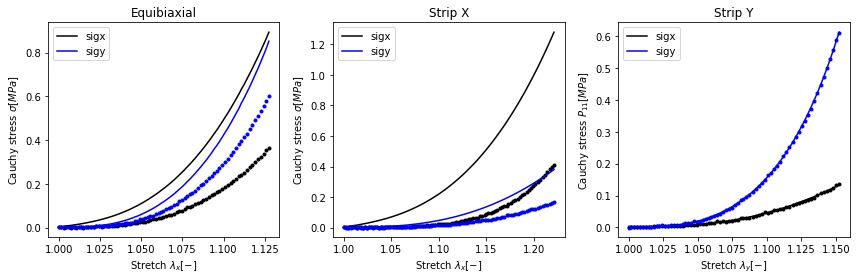

In [17]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = ICNN_model(params_icnn_sy[0], params_icnn_sy[1], params_icnn_sy[2], params_icnn_sy[3], params_icnn_sy[4], \
                 params_icnn_sy[5], params_icnn_sy[6], params_icnn_sy[7], params_icnn_sy[8], params_icnn_sy[9],normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('Figures/ICNN_skin_trained_sy.png',dpi=200)

In [18]:
# save the result with pickle
with open('savednet/ICNN_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_icnn_sy, f)

## CANN training

In [8]:
class CANN_model():
    def __init__(self, params_I1, params_I2, params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s,normalization):
        self.params_I1 = params_I1
        self.params_I2 = params_I2
        self.params_I4a = params_I4a
        self.params_I4s = params_I4s
        self.params_I1_I2  = params_I1_I2
        self.params_I1_I4a = params_I1_I4a
        self.params_I1_I4s = params_I1_I4s
        self.params_I2_I4a = params_I2_I4a
        self.params_I2_I4s = params_I2_I4s
        self.params_I4a_I4s = params_I4a_I4s
        self.normalization = normalization
    
    # Psi1
    def Psi1norm(self, I1norm):
        # Note: I1norm = (I1-3)/normalization
        return CANN_dpsidInorm(I1norm,self.params_I1)[:,0]/normalization[0]
    
    # Psi2
    def Psi2norm(self, I2norm):
        # Note: I2norm = (I2-3)/normalization
        return CANN_dpsidInorm(I2norm,self.params_I2)[:,0]/normalization[1]
    
    # mixed term with I4a and I1
    # output is derivative wrt I1
    def Psi_4a_1_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*alpha/normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4a_norm(self, I1norm, I4anorm):
        alpha = self.params_I1_I4a[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4anorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4a[:-1])[:,0]*(1-alpha)/normalization[2]
    
    # mixed term with I4s and I1
    # output is derivative wrt I1
    def Psi_4s_1_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*alpha/normalization[0]
    
    # mixed term with I4a and I1
    # output is derivative wrt I4a
    def Psi_1_4s_norm(self, I1norm, I4snorm):
        alpha = self.params_I1_I4s[-1]
        K = alpha*(I1norm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I1_I4s[:-1])[:,0]*(1-alpha)/normalization[3]
    
    # mixed term with I4s and I4a
    # output is derivative wrt I4a
    def Psi_4s_4a_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*alpha/normalization[2]
    
    # mixed term with I4a and I4s
    # output is derivative wrt I4s
    def Psi_4a_4s_norm(self, I4anorm, I4snorm):
        alpha = self.params_I4a_I4s[-1]
        K = alpha*(I4anorm) + (1-alpha)*(I4snorm)
        #normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,Psi1_factor,Psi2_factor,... ]
        return CANN_dpsidInorm(K,self.params_I4a_I4s[:-1])[:,0]*(1-alpha)/normalization[3]

In [30]:
params_I1 = init_params_cann(key)
params_I2 = init_params_cann(key)
params_I4a=[0.0]
params_I4s=[0.0]
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params_cann(key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params_cann(key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params_cann(key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_cann_all = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_all)
params_cann_all, train_loss, val_loss = train_jp(loss_sig_all, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 3.511114e-02
it 2000, train loss = 2.126794e-02
it 3000, train loss = 1.583983e-02
it 4000, train loss = 9.520767e-03
it 5000, train loss = 4.986315e-03
it 6000, train loss = 2.458630e-03
it 7000, train loss = 1.421630e-03
it 8000, train loss = 1.037921e-03
it 9000, train loss = 8.789820e-04
it 10000, train loss = 7.911047e-04
it 11000, train loss = 7.345547e-04
it 12000, train loss = 6.952647e-04
it 13000, train loss = 6.658755e-04
it 14000, train loss = 6.430388e-04
it 15000, train loss = 6.263712e-04
it 16000, train loss = 6.058984e-04
it 17000, train loss = 5.836712e-04
it 18000, train loss = 5.642034e-04
it 19000, train loss = 5.475016e-04
it 20000, train loss = 5.355582e-04
it 21000, train loss = 5.260547e-04
it 22000, train loss = 5.191721e-04
it 23000, train loss = 5.145962e-04
it 24000, train loss = 5.103161e-04
it 25000, train loss = 5.059663e-04
it 26000, train loss = 5.015292e-04
it 27000, train loss = 4.969904e-04
it 28000, train loss = 4.923413e-04
i

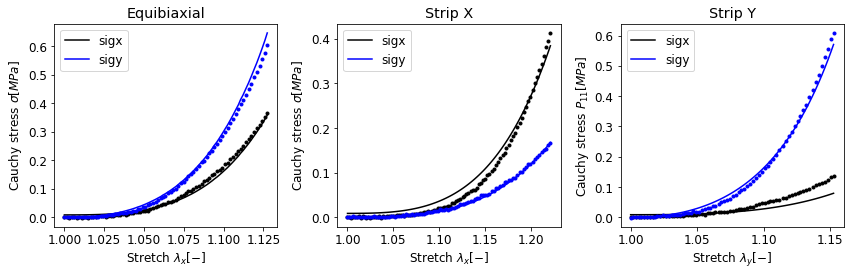

In [31]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = CANN_model(params_cann_all[0], params_cann_all[1], params_cann_all[2], params_cann_all[3], params_cann_all[4], \
                 params_cann_all[5], params_cann_all[6], params_cann_all[7], params_cann_all[8], params_cann_all[9],normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('Figures/CANN_skin_trained_all.png',dpi=200)

In [32]:
with open('savednet/CANN_skinparams_all.npy', 'wb') as f:
    pickle.dump(params_cann_all, f)

In [34]:
params_I1 = init_params_cann(key)
params_I2 = init_params_cann(key)
params_I4a=[0.0]
params_I4s=[0.0]
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params_cann(key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params_cann(key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params_cann(key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_cann_e = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_e)
params_cann_e, train_loss, val_loss = train_jp(loss_sig_e, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 3.548920e-02
it 2000, train loss = 2.428859e-02
it 3000, train loss = 1.618177e-02
it 4000, train loss = 8.960383e-03
it 5000, train loss = 4.151370e-03
it 6000, train loss = 1.754184e-03
it 7000, train loss = 7.848744e-04
it 8000, train loss = 3.882957e-04
it 9000, train loss = 2.100448e-04
it 10000, train loss = 1.058595e-04
it 11000, train loss = 3.652502e-05
it 12000, train loss = 2.752711e-05
it 13000, train loss = 2.470224e-05
it 14000, train loss = 2.242652e-05
it 15000, train loss = 2.027769e-05
it 16000, train loss = 1.819076e-05
it 17000, train loss = 1.621867e-05
it 18000, train loss = 1.446813e-05
it 19000, train loss = 1.302978e-05
it 20000, train loss = 1.186925e-05
it 21000, train loss = 1.093244e-05
it 22000, train loss = 1.023618e-05
it 23000, train loss = 9.732973e-06
it 24000, train loss = 9.326366e-06
it 25000, train loss = 8.918353e-06
it 26000, train loss = 8.488905e-06
it 27000, train loss = 8.045689e-06
it 28000, train loss = 7.623332e-06
i

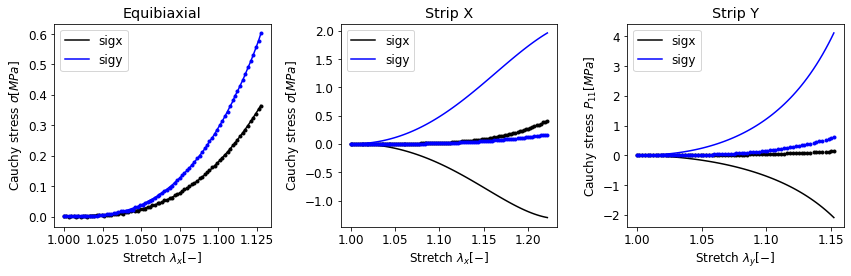

In [35]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = CANN_model(params_cann_e[0], params_cann_e[1], params_cann_e[2], params_cann_e[3], params_cann_e[4], \
                 params_cann_e[5], params_cann_e[6], params_cann_e[7], params_cann_e[8], params_cann_e[9],normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('Figures/CANN_skin_trained_e.png',dpi=200)

In [36]:
with open('savednet/CANN_skinparams_equi.npy', 'wb') as f:
    pickle.dump(params_cann_e, f)

In [38]:
params_I1 = init_params_cann(key)
params_I2 = init_params_cann(key)
params_I4a=[0.0]
params_I4s=[0.0]
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params_cann(key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params_cann(key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params_cann(key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_cann_sx = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_sx)
params_cann_sx, train_loss, val_loss = train_jp(loss_sig_sx, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 3.580798e-02
it 2000, train loss = 1.444956e-02
it 3000, train loss = 1.004592e-02
it 4000, train loss = 8.179573e-03
it 5000, train loss = 5.499042e-03
it 6000, train loss = 3.058887e-03
it 7000, train loss = 1.576252e-03
it 8000, train loss = 8.959993e-04
it 9000, train loss = 5.811687e-04
it 10000, train loss = 4.179644e-04
it 11000, train loss = 3.127312e-04
it 12000, train loss = 2.208439e-04
it 13000, train loss = 1.379452e-04
it 14000, train loss = 7.429992e-05
it 15000, train loss = 3.353675e-05
it 16000, train loss = 1.141374e-05
it 17000, train loss = 5.596073e-06
it 18000, train loss = 4.431233e-06
it 19000, train loss = 4.193052e-06
it 20000, train loss = 4.133214e-06
it 21000, train loss = 4.113997e-06
it 22000, train loss = 4.104404e-06
it 23000, train loss = 4.096940e-06
it 24000, train loss = 4.088509e-06
it 25000, train loss = 4.078626e-06
it 26000, train loss = 4.068472e-06
it 27000, train loss = 4.059411e-06
it 28000, train loss = 4.051930e-06
i

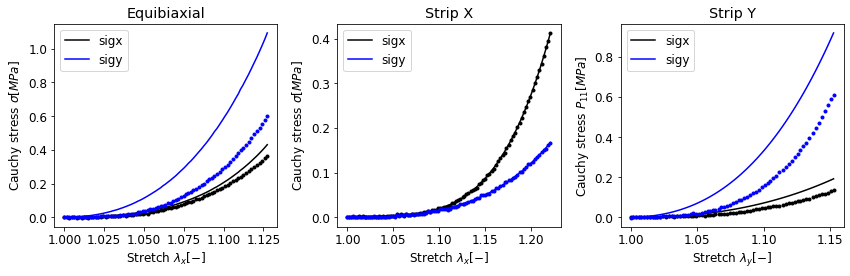

In [39]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = CANN_model(params_cann_sx[0], params_cann_sx[1], params_cann_sx[2], params_cann_sx[3], params_cann_sx[4], \
                 params_cann_sx[5], params_cann_sx[6], params_cann_sx[7], params_cann_sx[8], params_cann_sx[9],normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('Figures/CANN_skin_trained_sx.png',dpi=200)

In [40]:
with open('savednet/CANN_skinparams_sx.npy', 'wb') as f:
    pickle.dump(params_cann_sx, f)

In [42]:
params_I1 = init_params_cann(key)
params_I2 = init_params_cann(key)
params_I4a=[0.0]
params_I4s=[0.0]
params_I1_I2=[0.0]
params_I1_I2.append(0.0)
params_I1_I4a = init_params_cann(key)
#params_I1_I4a=[0.0]
params_I1_I4a.append(0.5)
params_I1_I4s = init_params_cann(key)
#params_I1_I4s=[0.0]
params_I1_I4s.append(0.5)
params_I2_I4a=[0.0]
params_I2_I4a.append(0.0)
params_I2_I4s=[0.0]
params_I2_I4s.append(0.0)
params_I4a_I4s = init_params_cann(key)
#params_I4a_I4s = [0.0]
params_I4a_I4s.append(0.5)

params_cann_sy = [params_I1,params_I2,params_I4a, params_I4s, params_I1_I2, \
                 params_I1_I4a, params_I1_I4s, params_I2_I4a, params_I2_I4s, params_I4a_I4s]
opt_init, opt_update, get_params = optimizers.adam(2.e-4) #Original: 1.e-4
opt_state = opt_init(params_cann_sy)
params_cann_sy, train_loss, val_loss = train_jp(loss_sig_sy, lamb_sigma, opt_state, key, nIter = 50000)

it 1000, train loss = 3.215888e-02
it 2000, train loss = 2.074624e-02
it 3000, train loss = 1.187557e-02
it 4000, train loss = 5.852249e-03
it 5000, train loss = 3.218119e-03
it 6000, train loss = 1.904418e-03
it 7000, train loss = 1.230229e-03
it 8000, train loss = 8.750887e-04
it 9000, train loss = 6.383412e-04
it 10000, train loss = 3.975703e-04
it 11000, train loss = 2.703449e-04
it 12000, train loss = 2.069752e-04
it 13000, train loss = 1.693495e-04
it 14000, train loss = 1.215383e-04
it 15000, train loss = 5.014832e-05
it 16000, train loss = 1.795727e-05
it 17000, train loss = 1.112469e-05
it 18000, train loss = 8.953607e-06
it 19000, train loss = 7.197955e-06
it 20000, train loss = 6.671558e-06
it 21000, train loss = 6.456862e-06
it 22000, train loss = 6.208119e-06
it 23000, train loss = 5.951394e-06
it 24000, train loss = 5.716580e-06
it 25000, train loss = 5.528079e-06
it 26000, train loss = 5.399397e-06
it 27000, train loss = 5.318921e-06
it 28000, train loss = 5.275671e-06
i

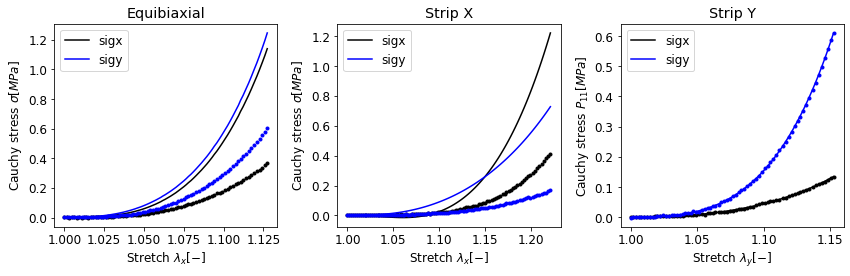

In [43]:
fig,axs = plt.subplots(1,3,figsize=(12,4))

model = CANN_model(params_cann_sy[0], params_cann_sy[1], params_cann_sy[2], params_cann_sy[3], params_cann_sy[4], \
                 params_cann_sy[5], params_cann_sy[6], params_cann_sy[7], params_cann_sy[8], params_cann_sy[9],normalization)
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]
sigx,sigy = eval_Cauchy(lambx,lamby, model, normalization)

axs[0].plot(lambx[0:ind_sx],sigmax[0:ind_sx] , 'k.')
axs[0].plot(lambx[0:ind_sx],sigx[0:ind_sx] ,color='black',label='sigx')
axs[0].plot(lambx[0:ind_sx],sigmay[0:ind_sx] , 'b.')
axs[0].plot(lambx[0:ind_sx],sigy[0:ind_sx] ,color='blue',label='sigy')
axs[0].legend(loc=2)
axs[0].set_title('Equibiaxial')
axs[0].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[0].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[1].plot(lambx[ind_sx:ind_sy],sigmax[ind_sx:ind_sy] , 'k.')
axs[1].plot(lambx[ind_sx:ind_sy],sigx[ind_sx:ind_sy] ,color='black',label='sigx')
axs[1].plot(lambx[ind_sx:ind_sy],sigmay[ind_sx:ind_sy] , 'b.')
axs[1].plot(lambx[ind_sx:ind_sy],sigy[ind_sx:ind_sy] ,color='blue',label='sigy')
axs[1].legend(loc=2)
axs[1].set_title('Strip X')
axs[1].set_xlabel(r'Stretch $\lambda_x [-]$')
axs[1].set_ylabel(r'Cauchy stress $\sigma [MPa]$')

axs[2].plot(lamby[ind_sy:],sigmax[ind_sy:] , 'k.')
axs[2].plot(lamby[ind_sy:],sigx[ind_sy:] ,color='black',label='sigx')
axs[2].plot(lamby[ind_sy:],sigmay[ind_sy:] , 'b.')
axs[2].plot(lamby[ind_sy:],sigy[ind_sy:] ,color='blue',label='sigy')
axs[2].legend(loc=2)
axs[2].set_title('Strip Y')
axs[2].set_xlabel(r'Stretch $\lambda_y [-]$')
axs[2].set_ylabel(r'Cauchy stress $P_{11} [MPa]$')

plt.tight_layout()
plt.savefig('Figures/CANN_skin_trained_sy.png',dpi=200)

In [44]:
with open('savednet/CANN_skinparams_sy.npy', 'wb') as f:
    pickle.dump(params_cann_sy, f)

# Plot everything

In [37]:
with open('savednet/NODE_skinparams_all.npy', 'rb') as f:
    node_params_a = pickle.load(f)
with open('savednet/NODE_skinparams_equi.npy', 'rb') as f:
    node_params_e = pickle.load(f)
with open('savednet/NODE_skinparams_sx.npy', 'rb') as f:
    node_params_sx = pickle.load(f)
with open('savednet/NODE_skinparams_sy.npy', 'rb') as f:
    node_params_sy = pickle.load(f)

with open('savednet/ICNN_skinparams_all.npy', 'rb') as f:
    icnn_params_a = pickle.load(f)
with open('savednet/ICNN_skinparams_equi.npy', 'rb') as f:
    icnn_params_e = pickle.load(f)
with open('savednet/ICNN_skinparams_sx.npy', 'rb') as f:
    icnn_params_sx = pickle.load(f)
with open('savednet/ICNN_skinparams_sy.npy', 'rb') as f:
    icnn_params_sy = pickle.load(f)

with open('savednet/CANN_skinparams_all.npy', 'rb') as f:
    cann_params_a = pickle.load(f)
with open('savednet/CANN_skinparams_equi.npy', 'rb') as f:
    cann_params_e = pickle.load(f)
with open('savednet/CANN_skinparams_sx.npy', 'rb') as f:
    cann_params_sx = pickle.load(f)
with open('savednet/CANN_skinparams_sy.npy', 'rb') as f:
    cann_params_sy = pickle.load(f)

with open('P12AC1_bsxsy.npy', 'rb') as f:
    lamb, sigma = np.load(f,allow_pickle=True)
lamb_sigma = np.hstack([lamb,sigma])
ind_sx = 81
ind_sy = 182

I1_factor = 5
I2_factor = 7
I4a_factor = 2
I4s_factor = 2
Psi1_factor = 0.5
Psi2_factor = 0.5
Psi4a_factor = 0.5
Psi4s_factor = 0.5
Psi_1_2_factor = 0.5
Psi_1_4a_factor = 0.5
Psi_1_4s_factor = 0.5
Psi_2_4a_factor = 0.5
Psi_2_4s_factor = 0.5
Psi_4a_4s_factor = 0.5
normalization = [I1_factor,I2_factor,I4a_factor,I4s_factor,\
                 Psi1_factor,Psi2_factor,Psi4a_factor,Psi4s_factor,\
                 Psi_1_2_factor,Psi_1_4a_factor,Psi_1_4s_factor,\
                 Psi_2_4a_factor,Psi_2_4s_factor, Psi_4a_4s_factor]

In [73]:
import pandas as pd
header = ['x', 'y1_gt', 'y2_gt', 'y1_node', 'y2_node', 'y1_cann', 'y2_cann', 'y1_icnn', 'y2_icnn']

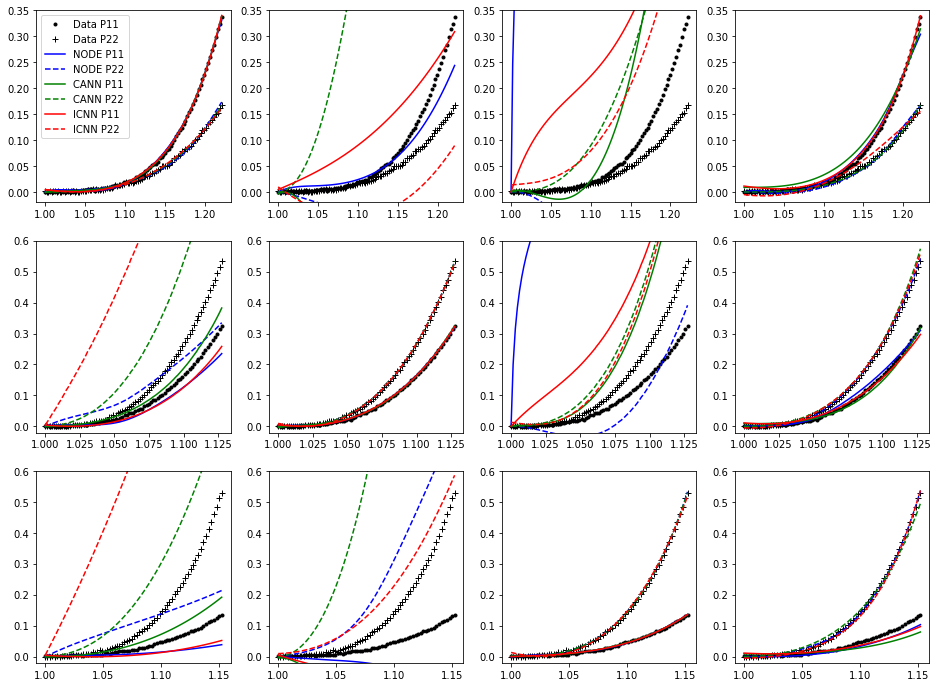

In [78]:
lambx = lamb_sigma[:,0]
lamby = lamb_sigma[:,1]
sigmax = lamb_sigma[:,2]
sigmay = lamb_sigma[:,3]

node_a = NODE_model(*node_params_a)
node_a_sigx,node_a_sigy = eval_Cauchy(lambx,lamby, node_a, normalization)
node_e = NODE_model(*node_params_e)
node_e_sigx,node_e_sigy = eval_Cauchy(lambx,lamby, node_e, normalization)
node_sx = NODE_model(*node_params_sx)
node_sx_sigx,node_sx_sigy = eval_Cauchy(lambx,lamby, node_sx, normalization)
node_sy = NODE_model(*node_params_sy)
node_sy_sigx,node_sy_sigy = eval_Cauchy(lambx,lamby, node_sy, normalization)

icnn_a = ICNN_model(*icnn_params_a, normalization)
icnn_a_sigx,icnn_a_sigy = eval_Cauchy(lambx,lamby, icnn_a, normalization)
icnn_e = ICNN_model(*icnn_params_e, normalization)
icnn_e_sigx,icnn_e_sigy = eval_Cauchy(lambx,lamby, icnn_e, normalization)
icnn_sx = ICNN_model(*icnn_params_sx, normalization)
icnn_sx_sigx,icnn_sx_sigy = eval_Cauchy(lambx,lamby, icnn_sx, normalization)
icnn_sy = ICNN_model(*icnn_params_sy, normalization)
icnn_sy_sigx,icnn_sy_sigy = eval_Cauchy(lambx,lamby, icnn_sy, normalization)

cann_a = CANN_model(*cann_params_a, normalization)
cann_a_sigx,cann_a_sigy = eval_Cauchy(lambx,lamby, cann_a, normalization)
cann_e = CANN_model(*cann_params_e, normalization)
cann_e_sigx,cann_e_sigy = eval_Cauchy(lambx,lamby, cann_e, normalization)
cann_sx = CANN_model(*cann_params_sx, normalization)
cann_sx_sigx,cann_sx_sigy = eval_Cauchy(lambx,lamby, cann_sx, normalization)
cann_sy = CANN_model(*cann_params_sy, normalization)
cann_sy_sigx,cann_sy_sigy = eval_Cauchy(lambx,lamby, cann_sy, normalization)


fig, ax = plt.subplots(3,4,figsize=(16,12))
ax[0,0].plot(lambx[ind_sx:ind_sy], sigmax[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'k.')
ax[0,0].plot(lambx[ind_sx:ind_sy], sigmay[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'k+')
ax[0,0].plot(lambx[ind_sx:ind_sy], node_sx_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'b-')
ax[0,0].plot(lambx[ind_sx:ind_sy], node_sx_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'b--')
ax[0,0].plot(lambx[ind_sx:ind_sy], cann_sx_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'g-')
ax[0,0].plot(lambx[ind_sx:ind_sy], cann_sx_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'g--')
ax[0,0].plot(lambx[ind_sx:ind_sy], icnn_sx_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'r-')
ax[0,0].plot(lambx[ind_sx:ind_sy], icnn_sx_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'r--')
data = np.array([lambx[ind_sx:ind_sy], 
                 sigmax[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 sigmay[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 node_sx_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 node_sx_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 cann_sx_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 cann_sx_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 icnn_sx_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy],
                 icnn_sx_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_a.csv', index=False, sep=' ')


ax[0,1].plot(lambx[ind_sx:ind_sy], sigmax[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'k.')
ax[0,1].plot(lambx[ind_sx:ind_sy], sigmay[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'k+')
ax[0,1].plot(lambx[ind_sx:ind_sy], node_e_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'b-')
ax[0,1].plot(lambx[ind_sx:ind_sy], node_e_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'b--')
ax[0,1].plot(lambx[ind_sx:ind_sy], cann_e_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'g-')
ax[0,1].plot(lambx[ind_sx:ind_sy], cann_e_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'g--')
ax[0,1].plot(lambx[ind_sx:ind_sy], icnn_e_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'r-')
ax[0,1].plot(lambx[ind_sx:ind_sy], icnn_e_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'r--')
data = np.array([lambx[ind_sx:ind_sy], 
                 sigmax[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 sigmay[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 node_e_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 node_e_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 cann_e_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 cann_e_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 icnn_e_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy],
                 icnn_e_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_b.csv', index=False, sep=' ')


ax[0,2].plot(lambx[ind_sx:ind_sy], sigmax[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'k.')
ax[0,2].plot(lambx[ind_sx:ind_sy], sigmay[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'k+')
ax[0,2].plot(lambx[ind_sx:ind_sy], node_sy_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'b-')
ax[0,2].plot(lambx[ind_sx:ind_sy], node_sy_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'b--')
ax[0,2].plot(lambx[ind_sx:ind_sy], cann_sy_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'g-')
ax[0,2].plot(lambx[ind_sx:ind_sy], cann_sy_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'g--')
ax[0,2].plot(lambx[ind_sx:ind_sy], icnn_sy_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'r-')
ax[0,2].plot(lambx[ind_sx:ind_sy], icnn_sy_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'r--')
data = np.array([lambx[ind_sx:ind_sy], 
                 sigmax[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 sigmay[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 node_sy_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 node_sy_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 cann_sy_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 cann_sy_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 icnn_sy_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy],
                 icnn_sy_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_c.csv', index=False, sep=' ')


ax[0,3].plot(lambx[ind_sx:ind_sy], sigmax[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'k.')
ax[0,3].plot(lambx[ind_sx:ind_sy], sigmay[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'k+')
ax[0,3].plot(lambx[ind_sx:ind_sy], node_a_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'b-')
ax[0,3].plot(lambx[ind_sx:ind_sy], node_a_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'b--')
ax[0,3].plot(lambx[ind_sx:ind_sy], cann_a_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'g-')
ax[0,3].plot(lambx[ind_sx:ind_sy], cann_a_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'g--')
ax[0,3].plot(lambx[ind_sx:ind_sy], icnn_a_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 'r-')
ax[0,3].plot(lambx[ind_sx:ind_sy], icnn_a_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy], 'r--')
data = np.array([lambx[ind_sx:ind_sy], 
                 sigmax[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 sigmay[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 node_a_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 node_a_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 cann_a_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy], 
                 cann_a_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy],
                 icnn_a_sigx[ind_sx:ind_sy]/lambx[ind_sx:ind_sy],
                 icnn_a_sigy[ind_sx:ind_sy]/lamby[ind_sx:ind_sy]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_d.csv', index=False, sep=' ')


ax[1,0].plot(lambx[:ind_sx], sigmax[:ind_sx]/lambx[:ind_sx], 'k.')
ax[1,0].plot(lambx[:ind_sx], sigmay[:ind_sx]/lamby[:ind_sx], 'k+')
ax[1,0].plot(lambx[:ind_sx], node_sx_sigx[:ind_sx]/lambx[:ind_sx], 'b-')
ax[1,0].plot(lambx[:ind_sx], node_sx_sigy[:ind_sx]/lamby[:ind_sx], 'b--')
ax[1,0].plot(lambx[:ind_sx], cann_sx_sigx[:ind_sx]/lambx[:ind_sx], 'g-')
ax[1,0].plot(lambx[:ind_sx], cann_sx_sigy[:ind_sx]/lamby[:ind_sx], 'g--')
ax[1,0].plot(lambx[:ind_sx], icnn_sx_sigx[:ind_sx]/lambx[:ind_sx], 'r-')
ax[1,0].plot(lambx[:ind_sx], icnn_sx_sigy[:ind_sx]/lamby[:ind_sx], 'r--')
data = np.array([lambx[:ind_sx], 
                 sigmax[:ind_sx]/lambx[:ind_sx], 
                 sigmay[:ind_sx]/lamby[:ind_sx],
                 node_sx_sigx[:ind_sx]/lambx[:ind_sx], 
                 node_sx_sigy[:ind_sx]/lamby[:ind_sx],
                 cann_sx_sigx[:ind_sx]/lambx[:ind_sx], 
                 cann_sx_sigy[:ind_sx]/lamby[:ind_sx],
                 icnn_sx_sigx[:ind_sx]/lambx[:ind_sx],
                 icnn_sx_sigy[:ind_sx]/lamby[:ind_sx]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_e.csv', index=False, sep=' ')


ax[1,1].plot(lambx[:ind_sx], sigmax[:ind_sx]/lambx[:ind_sx], 'k.')
ax[1,1].plot(lambx[:ind_sx], sigmay[:ind_sx]/lamby[:ind_sx], 'k+')
ax[1,1].plot(lambx[:ind_sx], node_e_sigx[:ind_sx]/lambx[:ind_sx], 'b-')
ax[1,1].plot(lambx[:ind_sx], node_e_sigy[:ind_sx]/lamby[:ind_sx], 'b--')
ax[1,1].plot(lambx[:ind_sx], cann_e_sigx[:ind_sx]/lambx[:ind_sx], 'g-')
ax[1,1].plot(lambx[:ind_sx], cann_e_sigy[:ind_sx]/lamby[:ind_sx], 'g--')
ax[1,1].plot(lambx[:ind_sx], icnn_e_sigx[:ind_sx]/lambx[:ind_sx], 'r-')
ax[1,1].plot(lambx[:ind_sx], icnn_e_sigy[:ind_sx]/lamby[:ind_sx], 'r--')
data = np.array([lambx[:ind_sx], 
                 sigmax[:ind_sx]/lambx[:ind_sx], 
                 sigmay[:ind_sx]/lamby[:ind_sx],
                 node_e_sigx[:ind_sx]/lambx[:ind_sx], 
                 node_e_sigy[:ind_sx]/lamby[:ind_sx],
                 cann_e_sigx[:ind_sx]/lambx[:ind_sx], 
                 cann_e_sigy[:ind_sx]/lamby[:ind_sx],
                 icnn_e_sigx[:ind_sx]/lambx[:ind_sx],
                 icnn_e_sigy[:ind_sx]/lamby[:ind_sx]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_f.csv', index=False, sep=' ')


ax[1,2].plot(lambx[:ind_sx], sigmax[:ind_sx]/lambx[:ind_sx], 'k.')
ax[1,2].plot(lambx[:ind_sx], sigmay[:ind_sx]/lamby[:ind_sx], 'k+')
ax[1,2].plot(lambx[:ind_sx], node_sy_sigx[:ind_sx]/lambx[:ind_sx], 'b-')
ax[1,2].plot(lambx[:ind_sx], node_sy_sigy[:ind_sx]/lamby[:ind_sx], 'b--')
ax[1,2].plot(lambx[:ind_sx], cann_sy_sigx[:ind_sx]/lambx[:ind_sx], 'g-')
ax[1,2].plot(lambx[:ind_sx], cann_sy_sigy[:ind_sx]/lamby[:ind_sx], 'g--')
ax[1,2].plot(lambx[:ind_sx], icnn_sy_sigx[:ind_sx]/lambx[:ind_sx], 'r-')
ax[1,2].plot(lambx[:ind_sx], icnn_sy_sigy[:ind_sx]/lamby[:ind_sx], 'r--')
data = np.array([lambx[:ind_sx], 
                 sigmax[:ind_sx]/lambx[:ind_sx], 
                 sigmay[:ind_sx]/lamby[:ind_sx],
                 node_sy_sigx[:ind_sx]/lambx[:ind_sx], 
                 node_sy_sigy[:ind_sx]/lamby[:ind_sx],
                 cann_sy_sigx[:ind_sx]/lambx[:ind_sx], 
                 cann_sy_sigy[:ind_sx]/lamby[:ind_sx],
                 icnn_sy_sigx[:ind_sx]/lambx[:ind_sx],
                 icnn_sy_sigy[:ind_sx]/lamby[:ind_sx]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_g.csv', index=False, sep=' ')


ax[1,3].plot(lambx[:ind_sx], sigmax[:ind_sx]/lambx[:ind_sx], 'k.')
ax[1,3].plot(lambx[:ind_sx], sigmay[:ind_sx]/lamby[:ind_sx], 'k+')
ax[1,3].plot(lambx[:ind_sx], node_a_sigx[:ind_sx]/lambx[:ind_sx], 'b-')
ax[1,3].plot(lambx[:ind_sx], node_a_sigy[:ind_sx]/lamby[:ind_sx], 'b--')
ax[1,3].plot(lambx[:ind_sx], cann_a_sigx[:ind_sx]/lambx[:ind_sx], 'g-')
ax[1,3].plot(lambx[:ind_sx], cann_a_sigy[:ind_sx]/lamby[:ind_sx], 'g--')
ax[1,3].plot(lambx[:ind_sx], icnn_a_sigx[:ind_sx]/lambx[:ind_sx], 'r-')
ax[1,3].plot(lambx[:ind_sx], icnn_a_sigy[:ind_sx]/lamby[:ind_sx], 'r--')
data = np.array([lambx[:ind_sx], 
                 sigmax[:ind_sx]/lambx[:ind_sx], 
                 sigmay[:ind_sx]/lamby[:ind_sx],
                 node_a_sigx[:ind_sx]/lambx[:ind_sx], 
                 node_a_sigy[:ind_sx]/lamby[:ind_sx],
                 cann_a_sigx[:ind_sx]/lambx[:ind_sx], 
                 cann_a_sigy[:ind_sx]/lamby[:ind_sx],
                 icnn_a_sigx[:ind_sx]/lambx[:ind_sx],
                 icnn_a_sigy[:ind_sx]/lamby[:ind_sx]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_h.csv', index=False, sep=' ')


ax[2,0].plot(lamby[ind_sy:], sigmax[ind_sy:]/lambx[ind_sy:], 'k.')
ax[2,0].plot(lamby[ind_sy:], sigmay[ind_sy:]/lamby[ind_sy:], 'k+')
ax[2,0].plot(lamby[ind_sy:], node_sx_sigx[ind_sy:]/lambx[ind_sy:], 'b-')
ax[2,0].plot(lamby[ind_sy:], node_sx_sigy[ind_sy:]/lamby[ind_sy:], 'b--')
ax[2,0].plot(lamby[ind_sy:], cann_sx_sigx[ind_sy:]/lambx[ind_sy:], 'g-')
ax[2,0].plot(lamby[ind_sy:], cann_sx_sigy[ind_sy:]/lamby[ind_sy:], 'g--')
ax[2,0].plot(lamby[ind_sy:], icnn_sx_sigx[ind_sy:]/lambx[ind_sy:], 'r-')
ax[2,0].plot(lamby[ind_sy:], icnn_sx_sigy[ind_sy:]/lamby[ind_sy:], 'r--')
data = np.array([lamby[ind_sy:], 
                 sigmax[ind_sy:]/lambx[ind_sy:], 
                 sigmay[ind_sy:]/lamby[ind_sy:],
                 node_sx_sigx[ind_sy:]/lambx[ind_sy:], 
                 node_sx_sigy[ind_sy:]/lamby[ind_sy:],
                 cann_sx_sigx[ind_sy:]/lambx[ind_sy:], 
                 cann_sx_sigy[ind_sy:]/lamby[ind_sy:],
                 icnn_sx_sigx[ind_sy:]/lambx[ind_sy:],
                 icnn_sx_sigy[ind_sy:]/lamby[ind_sy:]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_i.csv', index=False, sep=' ')


ax[2,1].plot(lamby[ind_sy:], sigmax[ind_sy:]/lambx[ind_sy:], 'k.')
ax[2,1].plot(lamby[ind_sy:], sigmay[ind_sy:]/lamby[ind_sy:], 'k+')
ax[2,1].plot(lamby[ind_sy:], node_e_sigx[ind_sy:]/lambx[ind_sy:], 'b-')
ax[2,1].plot(lamby[ind_sy:], node_e_sigy[ind_sy:]/lamby[ind_sy:], 'b--')
ax[2,1].plot(lamby[ind_sy:], cann_e_sigx[ind_sy:]/lambx[ind_sy:], 'g-')
ax[2,1].plot(lamby[ind_sy:], cann_e_sigy[ind_sy:]/lamby[ind_sy:], 'g--')
ax[2,1].plot(lamby[ind_sy:], icnn_e_sigx[ind_sy:]/lambx[ind_sy:], 'r-')
ax[2,1].plot(lamby[ind_sy:], icnn_e_sigy[ind_sy:]/lamby[ind_sy:], 'r--')
data = np.array([lamby[ind_sy:], 
                 sigmax[ind_sy:]/lambx[ind_sy:], 
                 sigmay[ind_sy:]/lamby[ind_sy:],
                 node_e_sigx[ind_sy:]/lambx[ind_sy:], 
                 node_e_sigy[ind_sy:]/lamby[ind_sy:],
                 cann_e_sigx[ind_sy:]/lambx[ind_sy:], 
                 cann_e_sigy[ind_sy:]/lamby[ind_sy:],
                 icnn_e_sigx[ind_sy:]/lambx[ind_sy:],
                 icnn_e_sigy[ind_sy:]/lamby[ind_sy:]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_j.csv', index=False, sep=' ')


ax[2,2].plot(lamby[ind_sy:], sigmax[ind_sy:]/lambx[ind_sy:], 'k.')
ax[2,2].plot(lamby[ind_sy:], sigmay[ind_sy:]/lamby[ind_sy:], 'k+')
ax[2,2].plot(lamby[ind_sy:], node_sy_sigx[ind_sy:]/lambx[ind_sy:], 'b-')
ax[2,2].plot(lamby[ind_sy:], node_sy_sigy[ind_sy:]/lamby[ind_sy:], 'b--')
ax[2,2].plot(lamby[ind_sy:], cann_sy_sigx[ind_sy:]/lambx[ind_sy:], 'g-')
ax[2,2].plot(lamby[ind_sy:], cann_sy_sigy[ind_sy:]/lamby[ind_sy:], 'g--')
ax[2,2].plot(lamby[ind_sy:], icnn_sy_sigx[ind_sy:]/lambx[ind_sy:], 'r-')
ax[2,2].plot(lamby[ind_sy:], icnn_sy_sigy[ind_sy:]/lamby[ind_sy:], 'r--')
data = np.array([lamby[ind_sy:], 
                 sigmax[ind_sy:]/lambx[ind_sy:], 
                 sigmay[ind_sy:]/lamby[ind_sy:],
                 node_sy_sigx[ind_sy:]/lambx[ind_sy:], 
                 node_sy_sigy[ind_sy:]/lamby[ind_sy:],
                 cann_sy_sigx[ind_sy:]/lambx[ind_sy:], 
                 cann_sy_sigy[ind_sy:]/lamby[ind_sy:],
                 icnn_sy_sigx[ind_sy:]/lambx[ind_sy:],
                 icnn_sy_sigy[ind_sy:]/lamby[ind_sy:]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_k.csv', index=False, sep=' ')


ax[2,3].plot(lamby[ind_sy:], sigmax[ind_sy:]/lambx[ind_sy:], 'k.')
ax[2,3].plot(lamby[ind_sy:], sigmay[ind_sy:]/lamby[ind_sy:], 'k+')
ax[2,3].plot(lamby[ind_sy:], node_a_sigx[ind_sy:]/lambx[ind_sy:], 'b-')
ax[2,3].plot(lamby[ind_sy:], node_a_sigy[ind_sy:]/lamby[ind_sy:], 'b--')
ax[2,3].plot(lamby[ind_sy:], cann_a_sigx[ind_sy:]/lambx[ind_sy:], 'g-')
ax[2,3].plot(lamby[ind_sy:], cann_a_sigy[ind_sy:]/lamby[ind_sy:], 'g--')
ax[2,3].plot(lamby[ind_sy:], icnn_a_sigx[ind_sy:]/lambx[ind_sy:], 'r-')
ax[2,3].plot(lamby[ind_sy:], icnn_a_sigy[ind_sy:]/lamby[ind_sy:], 'r--')
data = np.array([lamby[ind_sy:], 
                 sigmax[ind_sy:]/lambx[ind_sy:], 
                 sigmay[ind_sy:]/lamby[ind_sy:],
                 node_a_sigx[ind_sy:]/lambx[ind_sy:], 
                 node_a_sigy[ind_sy:]/lamby[ind_sy:],
                 cann_a_sigx[ind_sy:]/lambx[ind_sy:], 
                 cann_a_sigy[ind_sy:]/lamby[ind_sy:],
                 icnn_a_sigx[ind_sy:]/lambx[ind_sy:],
                 icnn_a_sigy[ind_sy:]/lamby[ind_sy:]]).T
df = pd.DataFrame(data, columns = header)
df.to_csv('TikZ_data/fig_skin1/fig_skin1_l.csv', index=False, sep=' ')

for axi in ax[0,:]:
    axi.set(ylim=[-0.020,0.35])
for axi in ax[1,:]:
    axi.set(ylim=[-0.020,0.6])
for axi in ax[2,:]:
    axi.set(ylim=[-0.020,0.6])

ax[0,0].legend(['Data P11', 'Data P22', 'NODE P11', 'NODE P22', 'CANN P11', 'CANN P22', 'ICNN P11', 'ICNN P22'])